In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import urllib.request
import os
import glob
import numpy as np
from PIL import Image
from keras.utils import to_categorical
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.models import Sequential
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,ZeroPadding2D
from keras import regularizers, optimizers
from sklearn.utils import shuffle
from keras.optimizers import SGD
from keras.models import Model
from tensorflow import keras
from keras.models import load_model
from keras.callbacks import EarlyStopping

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib
Found GPU at: /device:GPU:0


# Data Loading and Functions

In [ ]:
label_dir = '/content/drive/My Drive/DeepLearning/Project/Hyderabad_patches/Final_ProjectData/labels.csv'
data_dir = '/content/drive/My Drive/DeepLearning/Project/Hyderabad_patches/Final_ProjectData/Data/'
#models_dir = '/content/drive/My Drive/DeepLearning/DeepProject_UrbanAnalysis/Step2/Models/'
#new model directory
models_dir  ='/content/drive/My Drive/DeepLearning/Project/Hyderabad_patches/Models/'

In [ ]:
df_original = pd.read_csv(label_dir)
x_label , y_labels =  df_original.columns[0] , list(df_original.columns[1:])
df_original.head()

,ImageName,High Building Density,Moderate Building Density,Low Building Density,Regular Layout,Irregular Layout,Dense Greenery,Sparse Greenery,Very Sparse Greenery,Grass,Trees,Large Buildings,Exposed Soil
0,Hyderabad_1-1tile_10800-2200.png,0,0,1,0,1,0,1,0,0,1,0,1
1,Hyderabad_1-1tile_11000-11800.png,1,0,0,1,0,0,0,1,0,0,0,0
2,Hyderabad_1-1tile_10800-6800.png,0,0,1,0,1,0,0,1,0,0,0,1
3,Hyderabad_1-1tile_10600-11000.png,0,1,0,0,1,0,1,0,1,1,0,1
4,Hyderabad_1-1tile_11000-14200.png,1,0,0,0,1,0,0,1,0,0,0,0


In [ ]:
print(x_label)
print(list(y_labels))

ImageName
['High Building Density', 'Moderate Building Density', 'Low Building Density', 'Regular Layout', 'Irregular Layout', 'Dense Greenery', 'Sparse Greenery', 'Very Sparse Greenery', 'Grass', 'Trees', 'Large Buildings', 'Exposed Soil']


In [ ]:
#Dividing DataFrame Into Train Val Test
df = shuffle(df_original  ,random_state=2020)
df.reset_index(inplace=True, drop=True)
df_train, df_val, df_test = np.split(df, [int(.7 * len(df)), int(.85 * len(df))])

print("Total Data" , len(df))
print("Train Data:" , len(df_train),", Val Data:" , len(df_val)," Test Data:" , len(df_test))

Total Data 5078
Train Data: 3554 , Val Data: 762  Test Data: 762


#Functions

In [ ]:
def evaluate_model(model , test_generator  ):  #mode = ['multiclass' , 'multilabel']
  scores = model.evaluate(test_generator)
  print("Accuracy on test Data: " ,scores[1]*100)

  test_generator.reset()
  pred=model.predict_generator(test_generator,
            verbose=1)
  return scores[1] , pred
  
  # Printing Test Image with its predicted Labels
def Display_TestData(index , df_true, df_pred):

    print(df_true.iloc[index][x_label])
    true_labels = dict(df_true.iloc[index][df_true.iloc[index]==1])
    print("True Labels: \n",list(true_labels.keys()))

    pred_labels = dict(df_pred.iloc[index][df_pred.iloc[index]==1])
    print("Predicted Labels: \n",list(pred_labels.keys()))

    image_dir = data_dir + df_pred.iloc[index][x_label]  
    img=mpimg.imread(image_dir)
    imgplot = plt.imshow(img)
    plt.show()

In [ ]:
def plot_model_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [ ]:
datagen=ImageDataGenerator(rescale=1./255.)
val_datagen=ImageDataGenerator(rescale=1./255.)
test_datagen=ImageDataGenerator(rescale=1./255.)

train_generator=datagen.flow_from_dataframe(
              dataframe=df_train,
              directory=data_dir,
              x_col=x_label,
              y_col=y_labels,
              batch_size=32,
              seed=42,
              shuffle=True,
              class_mode="raw")


valid_generator=val_datagen.flow_from_dataframe(
              dataframe=df_val,
              directory=data_dir,
              x_col=x_label,
              y_col=y_labels,
              batch_size=32,
              seed=42,
              shuffle=True,
              class_mode="raw")

test_generator=test_datagen.flow_from_dataframe(
              dataframe=df_test,
              directory=data_dir,
              x_col=x_label,
              y_col=y_labels,
              batch_size=32,
              seed=42,
              shuffle=True,
              class_mode="raw")

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

Found 3554 validated image filenames.
Found 762 validated image filenames.
Found 762 validated image filenames.


#Training Backbone Model

In [ ]:

def define_model(in_shape=(256, 256, 3), out_shape=12):
  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=in_shape))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dense(out_shape, activation='sigmoid'))
  # compile model
  opt = SGD(lr=0.01, momentum=0.9)
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["accuracy"])
  return model


In [ ]:
def define_VGGmodel(in_shape=(256, 256, 3), out_shape=12):   
    model = Sequential([
    Conv2D(64, (3, 3), input_shape=in_shape,kernel_initializer='he_uniform' ,padding="same", activation="relu"),
    Conv2D(64, (3, 3), activation="relu", padding="same"),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(128, (3, 3), activation="relu",kernel_initializer='he_uniform', padding="same"),
    Conv2D(128, (3, 3), activation="relu", padding="same",),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(256, (3, 3), activation="relu",kernel_initializer='he_uniform' , padding="same",),
    Conv2D(256, (3, 3), activation="relu",kernel_initializer='he_uniform' , padding="same",),
    Conv2D(256, (3, 3), activation="relu",kernel_initializer='he_uniform' , padding="same",),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(512, (3, 3), activation="relu",kernel_initializer='he_uniform' , padding="same",),
    Conv2D(512, (3, 3), activation="relu",kernel_initializer='he_uniform' , padding="same",),
    Conv2D(512, (3, 3), activation="relu",kernel_initializer='he_uniform' , padding="same",),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Conv2D(512, (3, 3), activation="relu",kernel_initializer='he_uniform' ,padding="same",),
    Conv2D(512, (3, 3), activation="relu",kernel_initializer='he_uniform' , padding="same",),
    Conv2D(512, (3, 3), activation="relu",kernel_initializer='he_uniform' , padding="same",),
    MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),
    Flatten(),
    Dense(4096, activation="relu"),
    Dense(4096, activation="relu"),
    Dense(out_shape, activation="softmax")
    ])  
    opt = SGD(lr=0.01, momentum=0.9)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["accuracy"])

    return model

main_model = define_VGGmodel()

In [ ]:
main_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 256)      

### Steps for first time

Epoch 1/20
111/111 [==============================] - 148s 1s/step - loss: 1.0311 - accuracy: 0.5834 - val_loss: 0.9786 - val_accuracy: 0.5795
Epoch 2/20
111/111 [==============================] - 146s 1s/step - loss: 0.9643 - accuracy: 0.5836 - val_loss: 0.9686 - val_accuracy: 0.5771
Epoch 3/20
111/111 [==============================] - 146s 1s/step - loss: 0.9507 - accuracy: 0.5829 - val_loss: 1.0410 - val_accuracy: 0.5834
Epoch 4/20
111/111 [==============================] - 146s 1s/step - loss: 0.9368 - accuracy: 0.5840 - val_loss: 0.9301 - val_accuracy: 0.5761
Epoch 5/20
111/111 [==============================] - 146s 1s/step - loss: 0.9311 - accuracy: 0.5842 - val_loss: 0.9860 - val_accuracy: 0.5780
Epoch 6/20
111/111 [==============================] - 145s 1s/step - loss: 0.9301 - accuracy: 0.5829 - val_loss: 1.0088 - val_accuracy: 0.5837
Epoch 7/20
111/111 [==============================] - 144s 1s/step - loss: 0.9231 - accuracy: 0.5839 - val_loss: 0.9468 - val_accuracy: 0.5783

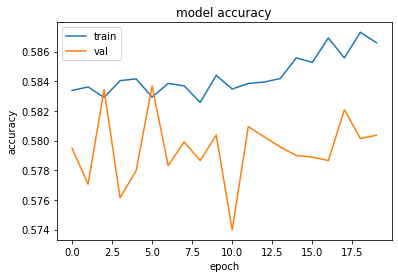

In [ ]:
opt = optimizers.adam(lr=0.0001,  decay=1e-6)
main_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["accuracy"])
history = main_model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20
)

plot_model_accuracy(history)
main_model.save(models_dir+ 'H_Model_VGG.h5')

Epoch 1/30
111/111 [==============================] - 147s 1s/step - loss: 0.7220 - accuracy: 0.5868 - val_loss: 1.0348 - val_accuracy: 0.5800
Epoch 2/30
111/111 [==============================] - 145s 1s/step - loss: 0.7028 - accuracy: 0.5882 - val_loss: 0.9804 - val_accuracy: 0.5816
Epoch 3/30
111/111 [==============================] - 145s 1s/step - loss: 0.7003 - accuracy: 0.5874 - val_loss: 1.0011 - val_accuracy: 0.5808
Epoch 4/30
111/111 [==============================] - 145s 1s/step - loss: 0.6972 - accuracy: 0.5879 - val_loss: 0.9480 - val_accuracy: 0.5765
Epoch 5/30
111/111 [==============================] - 145s 1s/step - loss: 0.6950 - accuracy: 0.5884 - val_loss: 1.0645 - val_accuracy: 0.5797
Epoch 6/30
111/111 [==============================] - 145s 1s/step - loss: 0.6983 - accuracy: 0.5873 - val_loss: 1.0552 - val_accuracy: 0.5806
Epoch 7/30
111/111 [==============================] - 145s 1s/step - loss: 0.7193 - accuracy: 0.5880 - val_loss: 1.1377 - val_accuracy: 0.5809

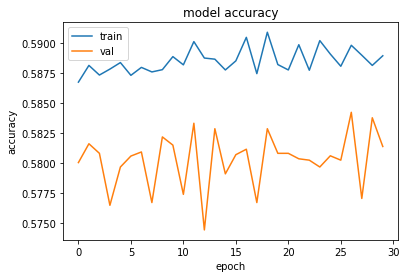

In [ ]:
opt = optimizers.adam(lr=0.0001,  decay=1e-6)
main_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["accuracy"])
history = main_model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=30
)

plot_model_accuracy(history)
main_model.save(models_dir+ 'H_Model_VGG.h5')

In [ ]:
acc  ,pred =   evaluate_model(main_model, test_generator)

24/24 [==============================] - 9s 381ms/step
Accuracy on test Data:  58.36614966392517
24/24 [==============================] - 15s 640ms/step


In [ ]:
main_model = load_model(models_dir+ 'H_Model_VGG.h5')

In [ ]:
sub_model = Sequential(main_model.layers[:-2])

In [ ]:
### Freeze all convolutions layers
for layer in sub_model.layers[:]:
    layer.trainable = False

sub_model.save(models_dir+'H_VGG_backbone.h5')

### For Manual Running

In [ ]:
sub_model= load_model((models_dir+'HF_VGG_backbone.h5', compile=False)

In [ ]:
sub_model.summary()

# Building Density Model

In [ ]:
Building_df_columns = ['ImageName','High Building Density', 'Moderate Building Density', 'Low Building Density']
Building_df_train =  df_train[Building_df_columns] 
Building_df_val   =  df_val[Building_df_columns] 
Building_df_test  =  df_test[Building_df_columns] 


Building_datagen     =ImageDataGenerator(rescale=1./255.)
Building_val_datagen =ImageDataGenerator(rescale=1./255.)
Building_test_datagen =ImageDataGenerator(rescale=1./255.)

Building_train_generator=Building_datagen.flow_from_dataframe(
                  dataframe=Building_df_train,
                  directory=data_dir,
                  x_col=x_label,
                  y_col=Building_df_columns[1:],
                  batch_size=32,
                  seed=42,
                  shuffle=True,
                  class_mode="raw")


Building_valid_generator=Building_val_datagen.flow_from_dataframe(
                  dataframe=Building_df_val,
                  directory=data_dir,
                  x_col=x_label,
                  y_col=Building_df_columns[1:],
                  batch_size=32,
                  seed=42,
                  shuffle=True,
                  class_mode="raw")

Building_test_generator=Building_test_datagen.flow_from_dataframe(
                  dataframe=Building_df_test,
                  directory=data_dir,
                  x_col=x_label,
                  y_col=Building_df_columns[1:],
                  batch_size=32,
                  seed=42,
                  shuffle=True,
                  class_mode="raw")

Found 3554 validated image filenames.
Found 762 validated image filenames.
Found 762 validated image filenames.


### Steps for first time

Epoch 1/10
111/111 [==============================] - 30s 267ms/step - loss: 0.6934 - accuracy: 0.6857 - val_loss: 0.5443 - val_accuracy: 0.7758
Epoch 2/10
111/111 [==============================] - 30s 273ms/step - loss: 0.4717 - accuracy: 0.7865 - val_loss: 0.4257 - val_accuracy: 0.7740
Epoch 3/10
111/111 [==============================] - 30s 269ms/step - loss: 0.3696 - accuracy: 0.8384 - val_loss: 0.4455 - val_accuracy: 0.7712
Epoch 4/10
111/111 [==============================] - 30s 267ms/step - loss: 0.2925 - accuracy: 0.8819 - val_loss: 0.3681 - val_accuracy: 0.7726
Epoch 5/10
111/111 [==============================] - 30s 266ms/step - loss: 0.2168 - accuracy: 0.9214 - val_loss: 0.5884 - val_accuracy: 0.7918
Epoch 6/10
111/111 [==============================] - 30s 266ms/step - loss: 0.1813 - accuracy: 0.9324 - val_loss: 0.3926 - val_accuracy: 0.7822
Epoch 7/10
111/111 [==============================] - 29s 266ms/step - loss: 0.1446 - accuracy: 0.9503 - val_loss: 0.8725 - val_ac

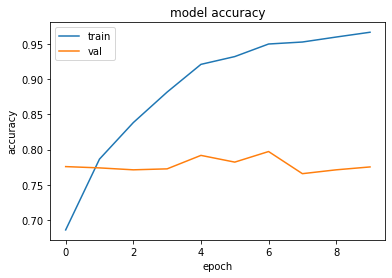

In [ ]:
Building_model = load_model(models_dir+'H_VGG_backbone.h5', compile=False)
Building_model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
Building_model.add(Dropout(0.5))
Building_model.add(Dense(3, activation='softmax'))

opt = optimizers.adam(lr=0.00001,  decay=1e-6)
Building_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])

B_history = Building_model.fit_generator(generator=Building_train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=Building_valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10)

plot_model_accuracy(B_history)

Building_model.save(models_dir +'H_VGG_Building_model.h5')

### For Manual Running

In [ ]:
Building_model = load_model(models_dir +'H_VGG_Building_model.h5')

In [ ]:
#Prediction 
b_acc  , b_pred =   evaluate_model(Building_model, Building_test_generator)

24/24 [==============================] - 131s 5s/step
Accuracy on test Data:  74.27821755409241
24/24 [==============================] - 6s 247ms/step


In [ ]:
b_prediction =to_categorical(np.argmax(b_pred, axis=1)).astype(int)
b_prediction[:10]

array([[0, 0, 1],
       [0, 0, 1],
       [1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0]])

# Pattern Model

In [ ]:
Pattern_df_columns = ['ImageName', 'Regular Layout', 'Irregular Layout']
Pattern_df_train =  df_train[Pattern_df_columns] 
Pattern_df_val   =  df_val[Pattern_df_columns] 
Pattern_df_test  =  df_test[Pattern_df_columns] 

Pattern_datagen     =ImageDataGenerator(rescale=1./255.)
Pattern_val_datagen =ImageDataGenerator(rescale=1./255.)
Pattern_test_datagen =ImageDataGenerator(rescale=1./255.)

Pattern_train_generator=Pattern_datagen.flow_from_dataframe(
                  dataframe=Pattern_df_train,
                  directory=data_dir,
                  x_col=x_label,
                  y_col=Pattern_df_columns[1:],
                  batch_size=32,
                  seed=42,
                  shuffle=True,
                  class_mode="raw")


Pattern_valid_generator=Pattern_val_datagen.flow_from_dataframe(
                  dataframe=Pattern_df_val,
                  directory=data_dir,
                  x_col=x_label,
                  y_col=Pattern_df_columns[1:],
                  batch_size=32,
                  seed=42,
                  shuffle=True,
                  class_mode="raw")

Pattern_test_generator= Pattern_test_datagen.flow_from_dataframe(
                  dataframe=Pattern_df_test,
                  directory=data_dir,
                  x_col=x_label,
                  y_col=Pattern_df_columns[1:],
                  batch_size=32,
                  seed=42,
                  shuffle=True,
                  class_mode="raw")

Found 3554 validated image filenames.
Found 762 validated image filenames.
Found 762 validated image filenames.


### Steps for first time

Epoch 1/10
111/111 [==============================] - 650s 6s/step - loss: 0.6274 - accuracy: 0.6706 - val_loss: 0.5871 - val_accuracy: 0.7357
Epoch 2/10
111/111 [==============================] - 31s 281ms/step - loss: 0.4777 - accuracy: 0.7685 - val_loss: 0.5183 - val_accuracy: 0.7260
Epoch 3/10
111/111 [==============================] - 32s 284ms/step - loss: 0.3982 - accuracy: 0.8221 - val_loss: 0.5565 - val_accuracy: 0.7322
Epoch 4/10
111/111 [==============================] - 32s 285ms/step - loss: 0.3226 - accuracy: 0.8708 - val_loss: 0.5686 - val_accuracy: 0.7247
Epoch 5/10
111/111 [==============================] - 30s 274ms/step - loss: 0.2786 - accuracy: 0.8897 - val_loss: 0.5590 - val_accuracy: 0.7322
Epoch 6/10
111/111 [==============================] - 30s 275ms/step - loss: 0.2373 - accuracy: 0.9127 - val_loss: 0.7451 - val_accuracy: 0.7185
Epoch 7/10
111/111 [==============================] - 30s 274ms/step - loss: 0.1960 - accuracy: 0.9304 - val_loss: 0.4841 - val_accu

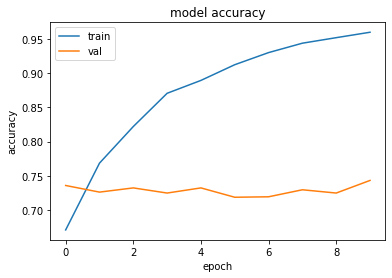

In [ ]:
Pattern_model = load_model(models_dir+'H_VGG_backbone.h5', compile=False)
Pattern_model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
Pattern_model.add(Dropout(0.5))
Pattern_model.add(Dense(2, activation='softmax'))

opt = optimizers.adam(lr=0.00001,  decay=1e-6)
Pattern_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["accuracy"])
P_history = Pattern_model.fit_generator(generator=Pattern_train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=Pattern_valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10)

plot_model_accuracy(P_history)
Pattern_model.save(models_dir +'H_VGG_Pattern_model.h5')

Epoch 1/10
111/111 [==============================] - 31s 281ms/step - loss: 0.6315 - accuracy: 0.6567 - val_loss: 0.7116 - val_accuracy: 0.6902
Epoch 2/10
111/111 [==============================] - 31s 283ms/step - loss: 0.5145 - accuracy: 0.7479 - val_loss: 0.5705 - val_accuracy: 0.7308
Epoch 3/10
111/111 [==============================] - 31s 282ms/step - loss: 0.4568 - accuracy: 0.7848 - val_loss: 0.4915 - val_accuracy: 0.7151
Epoch 4/10
111/111 [==============================] - 32s 284ms/step - loss: 0.3955 - accuracy: 0.8213 - val_loss: 0.6604 - val_accuracy: 0.7342
Epoch 5/10
111/111 [==============================] - 31s 279ms/step - loss: 0.3459 - accuracy: 0.8549 - val_loss: 0.5835 - val_accuracy: 0.7459
Epoch 6/10
111/111 [==============================] - 31s 279ms/step - loss: 0.3055 - accuracy: 0.8768 - val_loss: 0.5313 - val_accuracy: 0.7021
Epoch 7/10
111/111 [==============================] - 31s 284ms/step - loss: 0.2759 - accuracy: 0.8978 - val_loss: 0.6288 - val_ac

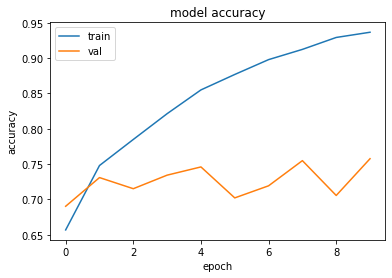

In [ ]:
Pattern_model = load_model(models_dir+'H_VGG_backbone.h5', compile=False)
Pattern_model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
Pattern_model.add(Dropout(0.5))
Pattern_model.add(Dense(2, activation='sigmoid'))

opt = optimizers.adam(lr=0.00001,  decay=1e-6)
Pattern_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["accuracy"])
P_history = Pattern_model.fit_generator(generator=Pattern_train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=Pattern_valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10)

plot_model_accuracy(P_history)
Pattern_model.save(models_dir +'H_VGG_Pattern_model.h5')

### For Manual Running

In [ ]:
Pattern_model= load_model(models_dir +'H_VGG_Pattern_model.h5')

In [ ]:
#Prediction 
p_acc  , p_pred =   evaluate_model(Pattern_model, Pattern_test_generator)
p_prediction = to_categorical(np.argmax(p_pred, axis=1)).astype(int)

24/24 [==============================] - 5s 227ms/step
Accuracy on test Data:  75.45931935310364
24/24 [==============================] - 5s 224ms/step


# Grass Sparsity Model

In [ ]:
Grass_df_columns = ['ImageName', 'Dense Greenery', 'Sparse Greenery', 'Very Sparse Greenery']
Grass_df_train =  df_train[Grass_df_columns] 
Grass_df_val   =  df_val[Grass_df_columns] 
Grass_df_test  =  df_test[Grass_df_columns] 

Grass_datagen      =   ImageDataGenerator(rescale=1./255.)
Grass_val_datagen  =   ImageDataGenerator(rescale=1./255.)
Grass_test_datagen = ImageDataGenerator(rescale=1./255.)

Grass_train_generator=Grass_datagen.flow_from_dataframe(
                  dataframe=Grass_df_train,
                  directory=data_dir,
                  x_col=x_label,
                  y_col=Grass_df_columns[1:],
                  batch_size=32,
                  seed=42,
                  shuffle=True,
                  class_mode="raw")


Grass_valid_generator=Grass_val_datagen.flow_from_dataframe(
                  dataframe=Grass_df_val,
                  directory=data_dir,
                  x_col=x_label,
                  y_col=Grass_df_columns[1:],
                  batch_size=32,
                  seed=42,
                  shuffle=True,
                  class_mode="raw")

Grass_test_generator= Grass_test_datagen.flow_from_dataframe(
                  dataframe=Grass_df_test,
                  directory=data_dir,
                  x_col=x_label,
                  y_col=Grass_df_columns[1:],
                  batch_size=32,
                  seed=42,
                  shuffle=True,
                  class_mode="raw")


Found 3554 validated image filenames.
Found 762 validated image filenames.
Found 762 validated image filenames.


### Steps for first time

In [ ]:
Grass_model = load_model(models_dir+'H_VGG_backbone.h5', compile=False)
Grass_model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
Grass_model.add(Dense(3, activation='softmax'))

opt = optimizers.adam(lr=0.00001,  decay=1e-6)
Grass_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=["accuracy"])
G_history = Grass_model.fit_generator(generator=Grass_train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=Grass_valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10)

Epoch 1/10
111/111 [==============================] - 30s 267ms/step - loss: 0.5665 - accuracy: 0.5508 - val_loss: 0.6103 - val_accuracy: 0.6019
Epoch 2/10
111/111 [==============================] - 30s 268ms/step - loss: 0.3779 - accuracy: 0.6823 - val_loss: 0.4863 - val_accuracy: 0.5808
Epoch 3/10
111/111 [==============================] - 31s 275ms/step - loss: 0.2921 - accuracy: 0.7209 - val_loss: 0.6106 - val_accuracy: 0.5671
Epoch 4/10
111/111 [==============================] - 30s 271ms/step - loss: 0.2250 - accuracy: 0.7655 - val_loss: 0.4532 - val_accuracy: 0.5767
Epoch 5/10
111/111 [==============================] - 30s 266ms/step - loss: 0.1815 - accuracy: 0.7862 - val_loss: 0.5454 - val_accuracy: 0.5726
Epoch 6/10
111/111 [==============================] - 29s 264ms/step - loss: 0.1497 - accuracy: 0.7942 - val_loss: 0.3996 - val_accuracy: 0.5836
Epoch 7/10
111/111 [==============================] - 29s 264ms/step - loss: 0.1309 - accuracy: 0.7936 - val_loss: 0.5168 - val_ac

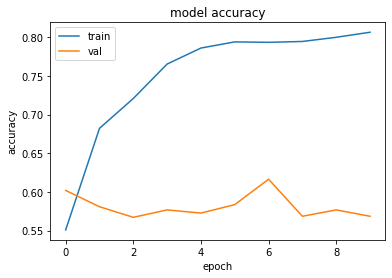

In [ ]:
plot_model_accuracy(G_history)
Grass_model.save(models_dir +'H_VGG_Grass_model.h5')

### For Manual Running

In [ ]:
Grass_model = load_model(models_dir +'H_VGG_Grass_model.h5')

In [ ]:
g_acc  , g_pred =   evaluate_model(Grass_model, Grass_test_generator)
g_prediction = to_categorical(np.argmax(g_pred, axis=1)).astype(int)

24/24 [==============================] - 6s 231ms/step
Accuracy on test Data:  58.923882246017456
24/24 [==============================] - 6s 230ms/step


# Extra Things Finder Model 

In [ ]:
Extra_df_columns = ['ImageName',  'Grass', 'Trees', 'Large Buildings', 'Exposed Soil']
Extra_df_train =  df_train[Extra_df_columns] 
Extra_df_val   =  df_val[Extra_df_columns] 
Extra_df_test  =  df_test[Extra_df_columns] 

Extra_datagen     =ImageDataGenerator(rescale=1./255.)
Extra_val_datagen =ImageDataGenerator(rescale=1./255.)
Extra_test_datagen =ImageDataGenerator(rescale=1./255.)

Extra_train_generator=Extra_datagen.flow_from_dataframe(
                  dataframe=Extra_df_train,
                  directory=data_dir,
                  x_col=x_label,
                  y_col=Extra_df_columns[1:],
                  batch_size=32,
                  seed=42,
                  shuffle=True,
                  class_mode="raw")


Extra_valid_generator=Extra_val_datagen.flow_from_dataframe(
                  dataframe=Extra_df_val,
                  directory=data_dir,
                  x_col=x_label,
                  y_col=Extra_df_columns[1:],
                  batch_size=32,
                  seed=42,
                  shuffle=True,
                  class_mode="raw")

Extra_test_generator= Extra_test_datagen.flow_from_dataframe(
                  dataframe=Extra_df_test,
                  directory=data_dir,
                  x_col=x_label,
                  y_col=Extra_df_columns[1:],
                  batch_size=32,
                  seed=42,
                  shuffle=True,
                  class_mode="raw")

STEP_SIZE_TRAIN=Extra_train_generator.n//Extra_train_generator.batch_size
STEP_SIZE_VALID=Extra_valid_generator.n//Extra_valid_generator.batch_size
STEP_SIZE_TEST=Extra_test_generator.n//Extra_test_generator.batch_size

Found 3554 validated image filenames.
Found 762 validated image filenames.
Found 762 validated image filenames.


### Steps for first time

Epoch 1/10
111/111 [==============================] - 32s 286ms/step - loss: 0.5515 - accuracy: 0.7286 - val_loss: 0.3969 - val_accuracy: 0.7728
Epoch 2/10
111/111 [==============================] - 33s 296ms/step - loss: 0.4924 - accuracy: 0.7593 - val_loss: 0.4561 - val_accuracy: 0.7637
Epoch 3/10
111/111 [==============================] - 32s 291ms/step - loss: 0.4569 - accuracy: 0.7787 - val_loss: 0.5153 - val_accuracy: 0.7493
Epoch 4/10
111/111 [==============================] - 32s 292ms/step - loss: 0.4156 - accuracy: 0.8005 - val_loss: 0.4701 - val_accuracy: 0.7777
Epoch 5/10
111/111 [==============================] - 32s 292ms/step - loss: 0.4016 - accuracy: 0.8083 - val_loss: 0.4437 - val_accuracy: 0.7630
Epoch 6/10
111/111 [==============================] - 32s 291ms/step - loss: 0.3569 - accuracy: 0.8331 - val_loss: 0.4654 - val_accuracy: 0.7685
Epoch 7/10
111/111 [==============================] - 33s 299ms/step - loss: 0.3397 - accuracy: 0.8425 - val_loss: 0.5744 - val_ac

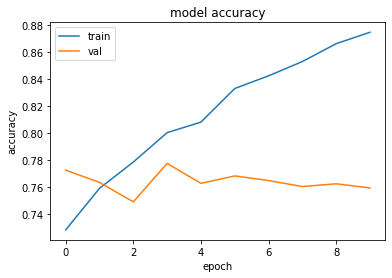

In [ ]:
Extra_model = load_model(models_dir+'H_VGG_backbone.h5', compile=False)
Extra_model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
Extra_model.add(Dropout(0.5))
Extra_model.add(Dense(4, activation='sigmoid'))
opt = optimizers.adam(lr=0.0001,  decay=1e-6)

Extra_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=["accuracy"])

E_history = Extra_model.fit_generator(generator=Extra_train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=Extra_valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10)
plot_model_accuracy(E_history)

Extra_model.save(models_dir +'H_VGG_Extra_model.h5')

### For Manual Running

In [ ]:
Extra_model = load_model(models_dir +'H_VGG_Extra_model.h5')

In [ ]:
e_acc  , e_pred =   evaluate_model( Extra_model, Extra_test_generator)
e_predictions = (e_pred > 0.5).astype(int)

24/24 [==============================] - 5s 227ms/step
Accuracy on test Data:  76.90288424491882
24/24 [==============================] - 5s 227ms/step


#Combining predictions

In [ ]:
predictions = np.concatenate((b_prediction,p_prediction,g_prediction,e_predictions) , axis =1)
predicted_df = pd.DataFrame(predictions, columns=y_labels) 
predicted_df[x_label]= df_test[x_label].to_list()
ordered_cols=[x_label]+y_labels
predicted_df=predicted_df[ordered_cols]
true_labels = df_test[y_labels].to_numpy()

In [ ]:
predicted_df.head()

,ImageName,High Building Density,Moderate Building Density,Low Building Density,Regular Layout,Irregular Layout,Dense Greenery,Sparse Greenery,Very Sparse Greenery,Grass,Trees,Large Buildings,Exposed Soil
0,Peshawar_1-1tile_11400-14400.png,0,0,1,0,1,1,0,0,1,1,0,1
1,Hyderabad_1-1tile_7400-5000.png,0,1,0,0,1,0,0,1,0,0,0,1
2,Peshawar_1-1tile_9800-14600.png,0,0,1,1,0,1,0,0,1,1,0,1
3,Lahore_image_1444.png,1,0,0,0,1,0,0,1,0,0,0,1
4,Peshawar_1-1tile_15200-17000.png,0,0,1,0,1,0,1,0,1,1,0,1


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(true_labels, predictions, target_names=y_labels))

                           precision    recall  f1-score   support

    High Building Density       0.24      0.18      0.20       162
Moderate Building Density       0.36      0.43      0.39       247
     Low Building Density       0.47      0.46      0.47       345
           Regular Layout       0.33      0.26      0.29       247
         Irregular Layout       0.65      0.75      0.70       497
           Dense Greenery       0.12      0.17      0.14        84
          Sparse Greenery       0.47      0.61      0.53       349
     Very Sparse Greenery       0.22      0.25      0.23       172
                    Grass       0.62      0.70      0.66       460
                    Trees       0.80      0.86      0.83       607
          Large Buildings       0.17      0.05      0.08       164
             Exposed Soil       0.65      0.72      0.68       494

                micro avg       0.54      0.58      0.56      3828
                macro avg       0.42      0.45      0.43    

#AHP

In [ ]:
AHP=[4.1, 15.5,6.8,31.9,1.7,2.1,6.0,2.1,4.9,5.9,13.3,5.6]
Planned_Scores= predictions @ AHP
Planned_Scores

array([30.9, 26. , 24.3, 23.2, 27. , 61.1, 27. , 10.6, 52.3, 39.6, 30.9,
       24.3, 30.9, 20.4, 54.5, 16.2, 61.1, 33.7, 30.9, 48.6, 14.5, 26. ,
       29.1, 27. , 34.7, 33.7, 39.6, 39.6, 16.5, 21.1, 39.6, 12.8, 16.5,
       39.6, 29.1, 35.7, 30.9, 34.7, 16.5, 30.9, 44.2, 30.9, 35.4, 39.6,
       27. , 17.7, 46.4, 58.4, 49.6, 27. , 34.7, 16.5, 47.3, 24.3, 35.7,
       29.1, 35.7, 65.9, 27. , 39.6, 60.3, 69.8, 34.7, 61.1, 39.6, 25.2,
       22.6, 13.8, 30.9, 35.7, 61.1, 68.8, 30.9, 30.9, 30.9, 55.5, 20.4,
       39.6, 26. , 34. , 64.2, 67.8, 34.7, 27. , 19.4, 54.5, 39.6, 35.7,
       13.8, 39.6, 40.3, 66.1, 25. , 14.5, 35.7, 24.3, 61.1, 74.4, 35.7,
       54.5, 30.9, 27. , 47.3, 61.1, 30.9, 61.1, 25.2, 74.4, 39.6, 34.7,
       16.5, 27. , 30.9, 16.5, 30.9, 34. , 24.3, 22.1, 27. , 27. , 39.6,
       24.2, 20.4, 20.4, 30.9, 39.6, 29.8, 35.7, 24.3, 54.5, 24.3, 69.8,
       13.8, 10.6, 70.5, 22.1, 56.2, 61. , 35.7, 69.8, 25. , 39.6, 33.7,
       33.7, 57.2, 29.8, 35.7, 57.2, 34.7,  7.9, 57